In [40]:
import torch
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from qna_essentials import QnAClassifier, create_data_loader, eval_model, get_tokenizer, load_custom_dataset

In [41]:
import matplotlib.pyplot as plt

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'deepset/gbert-base'
mfaq = load_custom_dataset("clips/mfaq", "de_flat", "validation")
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
class_names = ['nomatch', 'match']
BATCH_SIZE = 8
MAX_LEN = 512

Found cached dataset mfaq (C:/Users/Adam/.cache/huggingface/datasets/clips___mfaq/de_flat/1.1.0/046d91e0a0390af15e8521190b906d67fd3d4440839559764d1659f48a8dbe7c)
100%|██████████| 2/2 [00:00<00:00, 55.52it/s]


In [43]:
model = QnAClassifier(len(class_names), PRE_TRAINED_MODEL_NAME)
model.load_state_dict(torch.load("../models/qna_classifier_2023-03-28.bin"))
#model.load_state_dict(torch.load("../models/qna_classifier_2023-09-08.bin"))
model = model.to(device)

Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
def get_predictions(model, data_loader):
        model = model.eval()
        questions = []
        answers = []
        predictions = []
        prediction_probs = []
        real_values = []
        with torch.no_grad():
            for d in tqdm(data_loader):
                question_text = d["question_text"]
                answer_text = d["answer_text"]
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                _, preds = torch.max(outputs, dim=1)
                questions.extend(question_text)
                answers.extend(answer_text)
                predictions.extend(preds)
                prediction_probs.extend(outputs)
                real_values.extend(targets)
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return questions, answers, predictions, prediction_probs, real_values

In [45]:
mfaq_dl = create_data_loader(mfaq, tokenizer, MAX_LEN, BATCH_SIZE)
y_questions, y_answers, y_pred, y_pred_probs, y_test = get_predictions(
model,
mfaq_dl
)

  0%|          | 0/2033 [00:00<?, ?it/s]

100%|██████████| 2033/2033 [08:10<00:00,  4.14it/s]


In [46]:
y_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

In [47]:
y_test

tensor([1, 1, 1,  ..., 1, 1, 1])

In [48]:
y_pred_probs

tensor([[-5.9637,  4.4647],
        [-6.1695,  4.7278],
        [-6.1788,  4.7337],
        ...,
        [-6.1485,  4.7029],
        [-6.1297,  4.7396],
        [-6.1906,  4.7153]])

In [49]:
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Precision: 0.9617546432062561
Recall: 0.9681426814268143
Accuracy: 0.964823811573704


In [50]:
print(metrics.classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     nomatch       0.97      0.96      0.96      8131
       match       0.96      0.97      0.96      8130

    accuracy                           0.96     16261
   macro avg       0.96      0.96      0.96     16261
weighted avg       0.96      0.96      0.96     16261



In [51]:
print(metrics.confusion_matrix(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

[[7818  313]
 [ 259 7871]]


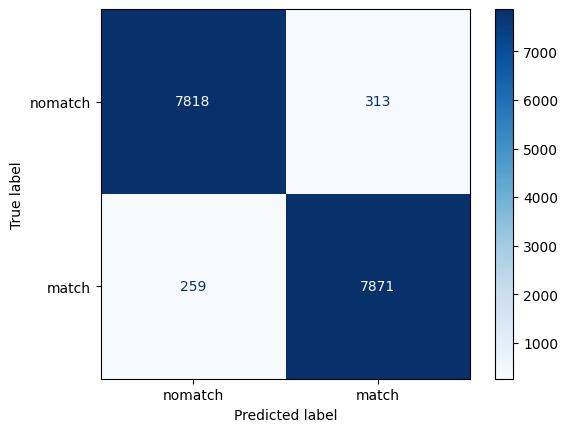

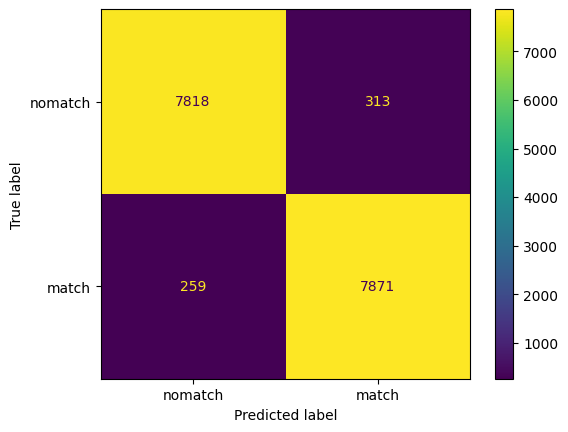

In [52]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=class_names, cmap=plt.cm.Blues)
cm_display.plot()